In [136]:
PROGRAM_RUN_COMMAND = "./dft"

In [137]:
!g++ -fopenmp -O2 -std=c++17 -o dft dft.cpp

In [138]:
from dataclasses import dataclass
import subprocess
import os
from typing import Tuple
import pandas as pd


@dataclass
class PlotData:
    accuracy: int
    thread_num: int
    compress_speedup: float
    naive_compress_speedup: float
    decompress_speedup: float


@dataclass
class Result:
    accuracy: int
    thread_num: int
    seq_compress_time: float
    seq_decompress_time: float
    par_fast_compress_time: float
    par_naive_compress_time: float
    par_decompress_time: float

    def _div(self, a: float, b: float) -> float:
        if b == 0:
            return float("inf")
        return a / b

    def to_plot_data(self) -> PlotData:
        return PlotData(
            accuracy=self.accuracy,
            thread_num=self.thread_num,
            compress_speedup=self._div(self.seq_compress_time, self.par_fast_compress_time),
            naive_compress_speedup=self._div(self.seq_compress_time, self.par_naive_compress_time),
            decompress_speedup=self._div(self.seq_decompress_time, self.par_decompress_time)
        )


def line_to_str_float_pair(line: str) -> Tuple[str, float]:
    key, value = line.split(":")
    return key.lower(), float(value)


ACCURACY = "ACCURACY"
THREAD_NUM = "OMP_NUM_THREADS"
def run(accuracy: int, thread_num: int) -> PlotData:
    env = os.environ.copy()
    env[ACCURACY] = str(accuracy)
    env[THREAD_NUM] = str(thread_num)
    result = subprocess.run([PROGRAM_RUN_COMMAND], env=env, capture_output=True, text=True)
    if result.returncode != 0:
        print(result.stderr)
        raise ValueError("Program failed")
    dict_result = dict([line_to_str_float_pair(line) for line in result.stdout.split("\n") if line])
    return Result(**dict_result, accuracy=accuracy, thread_num=thread_num).to_plot_data()

In [139]:
THREADS = [1, 2, 4, 8, 16, 32, 64]
ACCURACIES = [8, 16, 32]

results = [
    run(accuracy, thread_num)
    for accuracy in ACCURACIES
    for thread_num in THREADS
]

In [140]:
df = pd.DataFrame(results)
df

,accuracy,thread_num,compress_speedup,naive_compress_speedup,decompress_speedup
0,8,1,0.950173,0.555524,1.521803
1,8,2,1.720930,0.167918,2.351544
2,8,4,3.365217,0.142541,3.543011
3,8,8,4.000000,0.170405,3.636697
4,8,16,2.681883,0.177795,0.753811
5,8,32,2.006410,0.170186,0.340500
6,8,64,1.127088,0.159154,0.167811
7,16,1,0.958828,0.590455,1.461291
8,16,2,1.809589,0.372638,2.401289
9,16,4,3.496144,0.200452,3.875568


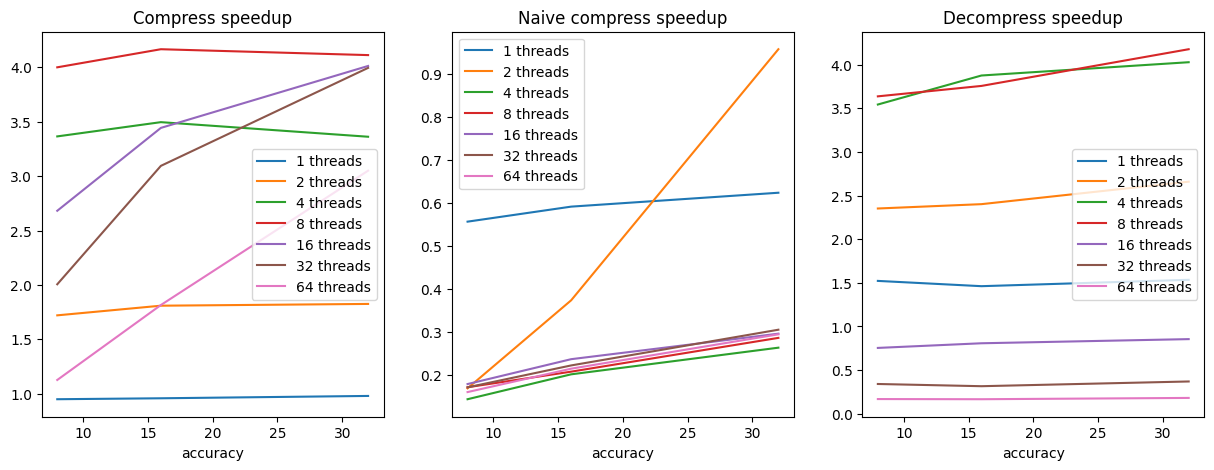

In [146]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, thread_num in enumerate(THREADS):
    df[df.thread_num == thread_num].plot(x="accuracy", y="compress_speedup", ax=axs[0], label=f"{thread_num} threads", title="Compress speedup")
    df[df.thread_num == thread_num].plot(x="accuracy", y="naive_compress_speedup", ax=axs[1], label=f"{thread_num} threads", title="Naive compress speedup")
    df[df.thread_num == thread_num].plot(x="accuracy", y="decompress_speedup", ax=axs[2], label=f"{thread_num} threads", title="Decompress speedup")
plt.savefig("speedup(accuracy) with fixed thread_num.png")
plt.show()
plt.close()

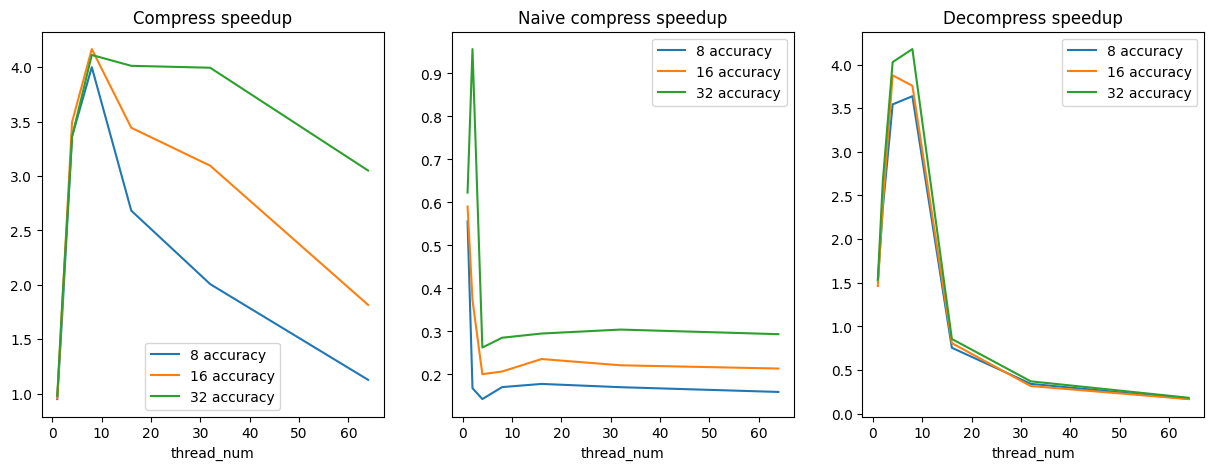

In [147]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, accuracy in enumerate(ACCURACIES):
    df[df.accuracy == accuracy].plot(x="thread_num", y="compress_speedup", ax=axs[0], label=f"{accuracy} accuracy", title="Compress speedup")
    df[df.accuracy == accuracy].plot(x="thread_num", y="naive_compress_speedup", ax=axs[1], label=f"{accuracy} accuracy", title="Naive compress speedup")
    df[df.accuracy == accuracy].plot(x="thread_num", y="decompress_speedup", ax=axs[2], label=f"{accuracy} accuracy", title="Decompress speedup")
plt.savefig("speedup(thread_num) with fixed accuracy.png")
plt.show()
plt.close()